In [71]:
from ge import Node2Vec
from geopy.distance import geodesic
import networkx as nx
import pickle as pkl
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings("ignore")
type2eng = {'旅游景点;公园': 'Attraction;Park', '教育培训;高等院校': 'Education;School', '购物;购物中心': 'Shopping;Mall', '医疗;综合医院': 'Medical;Hospital', '运动健身;体育场馆': 'Sport;Stadium', '旅游景点;文物古迹': 'Attraction;Monument', '旅游景点;风景区': 'Attraction;Scenic', '交通设施;火车站': 'Transportation;Train', '交通设施;长途汽车站': 'Transportation;Bus', '旅游景点;植物园': 'Attraction;Arboretum', '旅游景点;游乐园': 'Attraction;Amusement', '旅游景点;水族馆': 'Attraction;Aquarium', '旅游景点;动物园': 'Attraction;Zoo', '交通设施;飞机场': 'Transportation;Airport'}

## 1. load grid-flow-graph

In [11]:
grid_set = set()

with open('./data/datafountain_competition_od.txt') as f:
    for line in tqdm(f):
        cont = line.strip().split('\t')
        g1 = (round(float(cont[1]),4),round(float(cont[2]),3))
        g2 = (round(float(cont[3]),4),round(float(cont[4]),3))
        grid_set.add(g1)
        grid_set.add(g2)
        
len(grid_set)

9341613it [00:58, 159057.84it/s]


92471

In [12]:
grid_flow_graph = {i: {} for i in grid_set}

with open('./data/datafountain_competition_od.txt') as f:
    for line in tqdm(f):
        cont = line.strip().split('\t')
        g1 = (round(float(cont[1]),4),round(float(cont[2]),3))
        g2 = (round(float(cont[3]),4),round(float(cont[4]),3))

        hour = int(cont[0])
        weight = float(cont[-1])
        
        if g2 not in grid_flow_graph[g1]:
            grid_flow_graph[g1][g2] = {}
        if hour not in grid_flow_graph[g1][g2]:
            grid_flow_graph[g1][g2][hour] = []
        grid_flow_graph[g1][g2][hour] += [weight]
        

9341613it [01:49, 85529.51it/s] 


In [16]:
sum([len(k) for k in grid_flow_graph.values()])

7490188

In [65]:
'''
write grid_flow_graph
'''
with open('./cache/grid_flow_graph/grid_flow_graph.pkl', 'wb') as f:
    pkl.dump(grid_flow_graph, f)

## 2. build area-grid relation 

In [72]:
id2grid = {}
grid2id = {}
id2area = {}
id2cent = {}
id2sq = {}
id2type = {}
with open('./data/area_passenger_info.csv') as f:
    for line in f:
        cont = line.strip().split(',')
        g = (round(float(cont[5]),4),round(float(cont[6]),3))

        id2area[int(cont[0])] = cont[1]
        id2cent[int(cont[0])] = (float(cont[3]), float(cont[4]))
        id2grid[int(cont[0])] = g
        id2sq[int(cont[0])] = float(cont[-1])
        id2type[int(cont[0])] = type2eng[cont[2]].split(';')[0]
        
        if g not in grid2id:
            grid2id[g] = []
        grid2id[g].append(int(cont[0]))
        
print(len(id2grid), len(grid2id))

997 989


In [25]:
'''
由于一部分area所在的网格 并不在 grid_flow_graph中，需要找其邻近的网格进行补充
'''

id2grid_supply = {}

for g in tqdm(set(grid2id) - set(grid_flow_graph)):
    for aid in grid2id[g]:
        id2grid_supply[aid] = {}
        min_dist = 1e9
        min_g = None
        gc = id2cent[aid]
        for g1 in set(grid_flow_graph):
            dist = geodesic((gc[1],gc[0]),(g1[1],g1[0])).m
            if dist < min_dist:
                min_dist = dist
                min_g = g1
        id2grid_supply[aid]['grid'] = min_g
        id2grid_supply[aid]['sq'] = id2sq[aid]
        id2grid_supply[aid]['dist'] = min_dist

len(id2grid_supply)

100%|██████████| 101/101 [34:16<00:00, 20.36s/it]


101

In [26]:
'''
更新id2grid和grid2id
'''

id2grid_new = id2grid.copy()
grid2id_new = {}
for k,v in id2grid_supply.items():
    id2grid_new[k] = v['grid']

for k,v in id2grid_new.items():
    if k not in grid2id_new:
        grid2id_new[v] = [] # it's a bug !
    grid2id_new[v].append(k)

print(len(grid2id_new), len(id2grid_new))

988 997


In [66]:
'''
write id2grid & grid2id
'''
with open('./cache/grid_flow_graph/grid2id_new.pkl', 'wb') as f:
    pkl.dump(grid2id_new, f)
with open('./cache/grid_flow_graph/id2grid_new.pkl', 'wb') as f:
    pkl.dump(id2grid_new, f)

## 3. construct area-flow-graph

In [31]:
def construct_area_flow_graph(hour):
    '''
    construct area flow graph at an hour
    '''
    area_flow_graph = {}
    for aid in range(997):
        area_flow_graph[aid] = {}
        for k, v in grid_flow_graph[id2grid_new[aid+1]].items():
            aids_ = grid2id_new.get(k,None)
            if not aids_:
                continue
            for aid_ in aids_:
                aid_ = aid_ - 1
                w = v.get(hour, None)
                if not w:
                    continue
                area_flow_graph[aid][aid_] = max(w)
                
    return area_flow_graph

In [32]:
area_flow_hour_graph = {}
for h in range(24):
    area_flow_hour_graph[h] = construct_area_flow_graph(h)
    print(h, '孤立点个数:', sum([len(x) == 0 for x in area_flow_hour_graph[h].values()]))
    with open('./cache/area_flow_graph/area_flow_hour_graph_'+str(h)+'.edgelist', 'w') as f:
        for k, v in area_flow_hour_graph[h].items():
            f.write(str(k)+' '+str(k)+' '+str(0.5)+'\n')
            for k1,v1 in v.items():
                f.write(str(k)+' '+str(k1)+' '+str(v1)+'\n')

0 孤立点个数: 974
1 孤立点个数: 972
2 孤立点个数: 983
3 孤立点个数: 981
4 孤立点个数: 966
5 孤立点个数: 918
6 孤立点个数: 850
7 孤立点个数: 769
8 孤立点个数: 733
9 孤立点个数: 712
10 孤立点个数: 690
11 孤立点个数: 654
12 孤立点个数: 657
13 孤立点个数: 656
14 孤立点个数: 656
15 孤立点个数: 671
16 孤立点个数: 647
17 孤立点个数: 610
18 孤立点个数: 662
19 孤立点个数: 734
20 孤立点个数: 790
21 孤立点个数: 810
22 孤立点个数: 879
23 孤立点个数: 971


## 4. run Node2Vec

In [48]:
MODEL = 'node2vec'
embed_size = 16
walk_length = 5
num_walks = 80

for h in range(24):
    print('Hour',h)
    G = nx.read_edgelist('./cache/area_flow_graph/area_flow_hour_graph_'+str(h)+'.edgelist', create_using=nx.DiGraph(), nodetype=None,
                         data=[('weight', float)])

    model = Node2Vec(G, walk_length, num_walks, workers=1,p=0.25,q=2 )
    model.train(embed_size=embed_size)
    embeddings = model.get_embeddings()

    eswl = 'es'+str(embed_size)+'_wl'+str(walk_length)+'_'
    with open('./cache/area_embedding/area_flow_hour_'+MODEL+'_embed_'+eswl+str(h)+'.pkl', 'wb') as f:
        pkl.dump(embeddings, f)

Hour 0
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 1
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 2
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 3
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 4
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 5
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 6
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 7
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 8
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 9
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 10
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 11
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 12
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 13
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 14
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 15
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 16
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 17
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 18
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 19
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 20
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 21
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 22
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Hour 23
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


Learning embedding vectors...
Learning embedding vectors done!


## 5. plot

In [59]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(X, Y, embeddings):
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i], [])
        color_idx[Y[i]].append(i)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)

    plt.legend()
    plt.show()

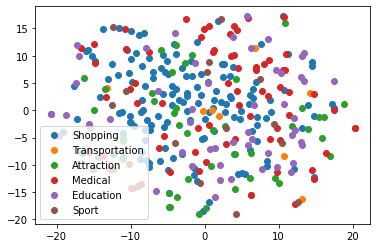

In [74]:
h = 14
type2idx, idx = {}, 0
X, Y = [], []
for k, v in area_flow_hour_graph[h].items():
    if len(v) == 0:
        continue
    y = id2type[k+1]
    if y not in type2idx:
        type2idx[y] = idx
        idx += 1
    X.append(str(k))
    Y.append(y)
    
with open('./cache/area_embedding/area_flow_hour_'+MODEL+'_embed_'+eswl+str(h)+'.pkl', 'rb') as f:
    embeddings = pkl.load(f)
    
plot_embeddings(X, Y, embeddings)